In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import bs4
from bs4 import BeautifulSoup
from urllib.request import urlopen

import nltk
from nltk import bigrams, FreqDist

import matplotlib
import matplotlib.pyplot as plt

from string import punctuation

from wordcloud import WordCloud

## Extracting Comments and Ratings

In [2]:
#read all comments anad ratings of "Body Massage Wellness Spa" from Yelp into dictionary
df = {}
comments = []
ratings = []

for i in range(0,121,20):
    url = 'https://www.yelp.com/biz/body-massage-wellness-spa-denver?start={}'.format(i)    
    html = urlopen(url).read()
    soup = BeautifulSoup(html, "html.parser")    
    #print(soup[i].prettify())
    for j in soup.find_all("p", {"itemprop": "description"}):
        x = j.get_text()
        x = x.replace('\n',"")
        comments.append(x)    
    for r in soup.find_all('div', {"itemprop": "reviewRating"}):
        ratings.append(r.meta['content'])
 
df["Comments"] = comments  
df["Ratings"] = ratings
df=pd.DataFrame.from_dict(df)
df.head()

,Comments,Ratings
0,Contacted them through Yelp and the owner resp...,5.0
1,I had an amazing massage yesterday! I have bee...,5.0
2,Was in town for a work conference and realized...,5.0
3,My husband and I had the best massage here! I'...,5.0
4,I've had a pinched nerve in my neck and seriou...,5.0


In [3]:
#export the output of comments and ratings
df.to_csv(r'E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\spaReviews.csv')

## Data Cleaning

In [21]:
def RemoveStopWords(stopwords, myText):
    str_Text = str(list(myText)).lower()
    str_Text = str_Text.replace("body massage wellness spa", "place") #replce the store's name with "place" to get more correct count of words
    myText = nltk.word_tokenize(str_Text)    
    NewText = [w for w in myText if w not in stopwords and not w.isdigit()]
    NewText = nltk.Text(NewText)
    return NewText

def RemoveJunk(myText, Junk): 
    newText = []
    for i in myText:
        newword = " "
        for c in i:           
            if c not in Junk:               
                newword = newword + c
        newText.append(newword)
    newText = nltk.Text(newText)
    return newText

def MergeTokens(wordstems, myText):
    newlist = []
    for i in  myText:
        for check in wordstems:
            i = i.replace(check[0],check[1])
        newlist .append(i)     
    newText = nltk.Text(newlist)
    return newlist              

def CleanWords(myText):    
    #remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords += punctuation
    stopwords.extend([" ","``", "'s", "'ve", "would", "'m", "...", "us", "one", "yelp", "denver", "massage", "place", "n", "e", "n't"])
    myText = RemoveStopWords(stopwords, myText)
    #remove Junk
    Junk = ["-","?",".","(",")","\\", " ","!",",", "\"", "'"]    
    myText = RemoveJunk(myText, Junk)
    #Merge Token
    wordstems = ("massages", "massage"), ("lives", "life"),("recommend", "recommended"), ("go", "come"), ("comeing", "come"), ("coming", "come"),('recommendedededededed', "recommended") 
    myText = MergeTokens(wordstems, myText)
    #remove stopwords again
    myText = RemoveStopWords(stopwords, myText)
    
    return myText

CleanComments = CleanWords(df.Comments)
#list(CleanComments)

In [8]:
#export cleaning comments to text file
f = open(r"E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\CleanComments.txt",'a')
for i in CleanComments:
    f.write(i + " ")
f.close()

## Data Description

### Bar Charts

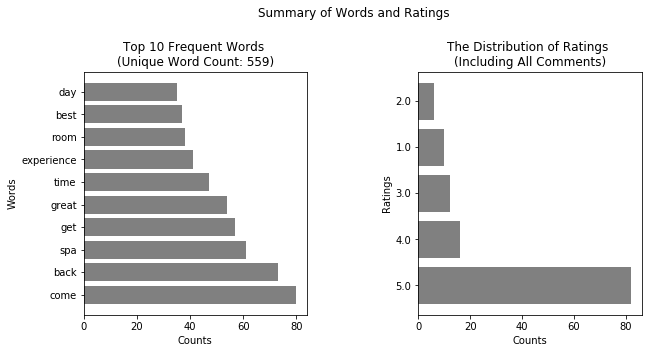

In [9]:
def GetFreqWords(CleanText):
    word_freq = dict([(word, CleanText.count(word)) for word in set(CleanText)])
    counts = pd.DataFrame.from_dict(word_freq, orient = 'index')
    counts = counts.reset_index()
    counts.columns = ['word', 'Count']
    counts = counts.sort_values('Count', ascending = False)
    counts = counts.loc[counts.Count > 2] #global frequency at least 3
    return counts

def BarPlots(FreqWords, top, df):  
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Summary of Words and Ratings')
    plt.subplots_adjust(top = 0.8, wspace=0.5)
    
    plt.subplot(1, 2, 1)    
    FreqWordsTop = FreqWords.iloc[:top]
    y = FreqWordsTop.Count
    n = len(y)
    x = np.arange(n)
    plt.barh(x, y, color = 'grey')
    plt.xlabel('Counts')
    plt.ylabel('Words')
    plt.yticks(x, FreqWordsTop.word)
    plt.title(f"Top {top} Frequent Words \n(Unique Word Count: {len(FreqWords)})")
    
    plt.subplot(1, 2, 2)
    Ratings_Counts = pd.DataFrame(df.Ratings.value_counts())
    y = Ratings_Counts.Ratings
    n = len(y)
    x = np.arange(n)
    plt.barh(x, y, color = 'grey')
    plt.title(f'The Distribution of Ratings \n(Including All Comments)')
    plt.xlabel('Counts')
    plt.ylabel('Ratings')
    plt.yticks(x, Ratings_Counts.index)
    
    plt.savefig(r'E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\BarCharts.png')
    plt.show()
    
FreqComments = GetFreqWords(CleanComments)
BarPlots(FreqComments, 10, df)

### Word Cloud

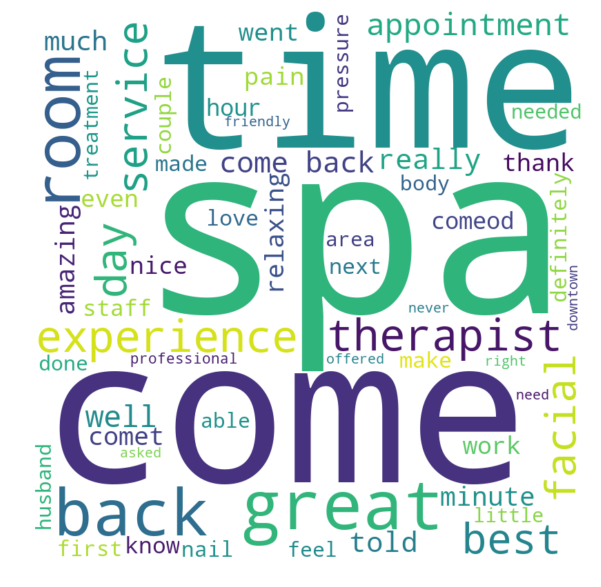

In [10]:
def create_wordcloud(myText):
    str_Text = " "
    for t in myText:
        str_Text = str_Text + t + " "
    
    wordcloud = WordCloud(width = 800, height = 800,
                          min_font_size = 20,
                          background_color ='white').generate(str_Text) 
              
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.savefig(r'E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\WordCloud.png')
    plt.show()

    
create_wordcloud(CleanComments)

### Bigrams Frequency

In [11]:
def GetBigrams(myText, top):
    bg = list(nltk.bigrams(myText))
    word_freq = dict([(word, bg.count(word)) for word in set(bg)])
    counts=pd.DataFrame.from_dict(word_freq, orient='index')
    counts=counts.reset_index()
    counts.columns = ['word','Count']
    counts = counts.sort_values('Count',ascending=False)
    counts = counts.iloc[:top]
    return counts 

top10bigram = GetBigrams(CleanComments,10)
top10bigram

,word,Count
4171,"(come, back)",30
4811,"(highly, recommended)",13
5263,"(deep, tissue)",11
2512,"(best, ever)",9
989,"(able, get)",7
2104,"(body, wellness)",7
3447,"(first, time)",7
4147,"(last, minute)",7
2620,"(front, desk)",6
3723,"(make, sure)",6


In [12]:
top10bigram.to_csv(r"E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\top10bigram.csv")

### Ngrams Frequency

#### Trigram

In [14]:
def GetNgrams(myText, n, top):
    bg = list(nltk.ngrams(myText,n))
    word_freq = dict([(word, bg.count(word)) for word in set(bg)])
    counts=pd.DataFrame.from_dict(word_freq, orient='index')
    counts=counts.reset_index()
    counts.columns = ['word','Count']
    counts = counts.sort_values('Count',ascending=False)
    counts = counts.iloc[:top]
    return counts 

top10trigram = GetNgrams(CleanComments, 3, 10) 
top10trigram

,word,Count
3452,"(laser, hair, removal)",4
5217,"(definitely, come, back)",4
3344,"(get, last, minute)",3
4750,"(last, minute, appointment)",3
1748,"(deep, tissue, trigger)",3
1108,"(back, next, time)",3
350,"(highly, recommended, spa)",3
1240,"(facial, products, face)",2
2395,"(room, wrapped, body)",2
360,"(spa, want, extremely)",2


#### four-gram

In [15]:
def GetNgrams(myText, n, top):
    bg = list(nltk.ngrams(myText,n))
    word_freq = dict([(word, bg.count(word)) for word in set(bg)])
    counts=pd.DataFrame.from_dict(word_freq, orient='index')
    counts=counts.reset_index()
    counts.columns = ['word','Count']
    counts = counts.sort_values('Count',ascending=False)
    counts = counts.iloc[:top]
    return counts 

top10fourgram = GetNgrams(CleanComments, 4, 10) 
top10fourgram

,word,Count
2364,"(get, last, minute, appointment)",2
4294,"(used, wipe, facial, products)",2
4840,"(unrelaxing, day, spa, called)",2
4459,"(great, deep, tissue, trigger)",2
581,"(able, get, last, minute)",2
1080,"(deep, tissue, trigger, points)",2
637,"(wrap, time, fair, enough)",2
5514,"(awkward, unrelaxing, day, spa)",2
185,"(room, wrapped, body, wrap)",2
4562,"(want, extremely, unprofessional, awkward)",2


In [16]:
top10trigram.to_csv(r"E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\top10trigram.csv")
top10fourgram.to_csv(r"E:\19 Fall\Complex\Lesson16Homework_Ruohua.Li\outputs\top10fourgram.csv")

## Sentiment Analysis

The sentiment analysis doesn't make sense, because the number of records is not large enough. Thus, I did not use it to color the word cloud

#### use unigram

In [17]:
df["Ratings"] = df["Ratings"].astype(float) 
postext = list(df['Comments'][df.Ratings > 3]) #we consider the comments generally are positive when they have 4 and 5 stars
negtext = list(df['Comments'][df.Ratings <= 3])

poslist = []
neglist = []

for i in postext:
    poslist.append((i, 'positive'))
    
for i in negtext:
    neglist.append((i, 'negative'))
    
    
taggedcomments = poslist + neglist
#print(taggedcomments)

listofwords = [i for i in CleanComments] #Clean words
#listofwords

taggedtokenreviews = [] #raw
for (word, sentiment) in taggedcomments:
    word_filter = [i for i in word.split()]
    taggedtokenreviews.append((word_filter, sentiment))
#print(taggedtokenreviews)

def feature_extractor(doc, wordfeats=None):
    wordfeats = listofwords
    docwords = set(doc) # creates unique collection of words
    
    has_features = {}
    for feat in wordfeats:

        if feat in docwords:
            has_features.update({feat: True})
        else:
            has_features.update({feat: False})
    return has_features
from nltk.classify.util import apply_features
#Creates a training set - classifier learns distribution of true/falses in the input.
training_set = nltk.classify.util.apply_features(feature_extractor, taggedtokenreviews)
#print(training_set)

classifier = nltk.NaiveBayesClassifier.train(training_set)
print (classifier.show_most_informative_features(n=30))

Most Informative Features
                    nail = True           negati : positi =     17.1 : 1.0
                    deal = True           negati : positi =     12.5 : 1.0
                     put = True           negati : positi =     10.2 : 1.0
                actually = True           negati : positi =     10.2 : 1.0
                   maybe = True           negati : positi =     10.2 : 1.0
                    tech = True           negati : positi =     10.2 : 1.0
                  polish = True           negati : positi =     10.2 : 1.0
                     due = True           negati : positi =     10.2 : 1.0
                   worth = True           negati : positi =     10.2 : 1.0
                    room = True           negati : positi =      8.7 : 1.0
                    pedi = True           negati : positi =      8.0 : 1.0
                  waited = True           negati : positi =      8.0 : 1.0
                    knew = True           negati : positi =      8.0 : 1.0

In [18]:
print('accuracy:', nltk.classify.util.accuracy(classifier, training_set))

accuracy: 0.9126984126984127


#### use bigram

In [19]:
poslist = []
neglist = []

for i in postext:
    poslist.append((nltk.bigrams(i), 'positive'))
    
for i in negtext:
    neglist.append((nltk.bigrams(i), 'negative'))
    
    
taggedcomments = poslist + neglist
#print(taggedcomments)

listofwords = [i for i in nltk.bigrams(CleanComments)] #Clean words
#listofwords

taggedtokenreviews = [] #raw
for (word, sentiment) in taggedcomments:
    word_filter = [i for i in word]
    taggedtokenreviews.append((word_filter, sentiment))
#print(taggedtokenreviews)

def feature_extractor(doc, wordfeats=None):
    wordfeats = listofwords
    docwords = set(doc) # creates unique collection of words
    
    has_features = {}
    for feat in wordfeats:

        if feat in docwords:
            has_features.update({feat: True})
        else:
            has_features.update({feat: False})
    return has_features
from nltk.classify.util import apply_features
#Creates a training set - classifier learns distribution of true/falses in the input.
training_set = nltk.classify.util.apply_features(feature_extractor, taggedtokenreviews)
#print(training_set)

classifier = nltk.NaiveBayesClassifier.train(training_set)
print (classifier.show_most_informative_features(n=30))

Most Informative Features
  ('services', 'thrown') = False          negati : positi =      1.0 : 1.0
        ('heck', 'time') = False          negati : positi =      1.0 : 1.0
    ('avoid', 'nothing') = False          negati : positi =      1.0 : 1.0
   ('setup', 'relaxing') = False          negati : positi =      1.0 : 1.0
    ('nice', 'relaxing') = False          negati : positi =      1.0 : 1.0
('definitely', 'little') = False          negati : positi =      1.0 : 1.0
      ('felt', 'looked') = False          negati : positi =      1.0 : 1.0
      ('make', 'really') = False          negati : positi =      1.0 : 1.0
       ('great', 'spot') = False          negati : positi =      1.0 : 1.0
       ('back', 'great') = False          negati : positi =      1.0 : 1.0
        ('says', 'room') = False          negati : positi =      1.0 : 1.0
     ('enjoyed', 'much') = False          negati : positi =      1.0 : 1.0
 ('late', 'appointment') = False          negati : positi =      1.0 : 1.0

In [20]:
print('accuracy:', nltk.classify.util.accuracy(classifier, training_set))

accuracy: 0.7777777777777778
